# Pandas 데모 - Explarotary Data Analysis

## 라이브러리 import 및 설정

In [137]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [138]:
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings

In [139]:
rcParams['figure.figsize'] = (18, 9)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 데이터 다운로드

데이터는 [Dacon 단국대 소/중 데이터 분석 AI 경진대회 웹사이트](https://www.dacon.io/competitions/official/235638/data/)에서 다운로드 받아 `../input` 폴더에 저장.

In [140]:
!ls -alF ../../input/

total 287952
drwxr-xr-x 2 swcu swcu      4096  9월 23 11:38 ./
drwxrwxr-x 8 swcu swcu      4096  9월 24 17:19 ../
-rw-r--r-- 1 swcu swcu  47899736  9월 18 02:22 ecminer_standard_normal_outlier_train.csv
-rw-r--r-- 1 swcu swcu 132585197  9월 24 15:52 feature.csv
-rw-r--r-- 1 swcu swcu    720009  9월 23 11:34 lgbm_u_r_i_z_redshift_du_dg_dr_di_dz.csv
-rw-r--r-- 1 swcu swcu    800010  7월 26 13:35 sample_submission.csv
-rw-r--r-- 1 swcu swcu  17619545  9월 18 01:17 standard_normal_test.xlsx
-rw-r--r-- 1 swcu swcu  18936246  7월 26 13:35 test.csv
-rw-r--r-- 1 swcu swcu  76278443  7월 26 13:35 train.csv


In [141]:
data_dir = Path('../../input/')
trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
feature_file = data_dir / 'feature.csv'
sample_file = data_dir / 'sample_submission.csv'
sub_dir = Path('../../sub')
target_col = 'class'
seed = 42

In [142]:
algo_name = 'lgb'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

#feature_file = feature_dir / f'{feature_name}.csv'
sub_file = sub_dir / f'{model_name}.csv'

## EDA

In [143]:
trn = pd.read_csv(trn_file, index_col=0)
print(trn.shape)
trn.head()

(320000, 19)


,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
id,,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057,0
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941,0


## 데이터 개요

In [144]:
trn.describe()

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
count,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,3.2000e+05,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000
mean,19.8524,18.3768,17.7358,17.1742,16.8752,5.8308e-02,19.6289,18.2271,17.6154,17.1523,16.8693,6.3327,6.1388,1.1758,1.1765,1.1751,1.1754,1.1761,1.1163
std,1.9455,31.1108,1.4662,52.5615,57.1463,5.7546e-01,1.9236,17.7866,1.4730,25.0758,35.4365,8.8811,8.5516,0.1163,0.1181,0.1147,0.1155,0.1172,0.9235
min,-17.6875,-17555.3656,7.7314,-23955.8178,-23955.8178,-1.6605e+02,-42.8375,-9999.0000,-16.3802,-9999.0000,-9999.0000,1.0000,1.0000,1.0001,1.0000,1.0002,1.0001,1.0000,0.0000
25%,18.7242,17.4749,16.8772,16.5239,16.2889,3.5580e-05,18.5636,17.3484,16.7871,16.4530,16.2341,1.0000,1.0000,1.0882,1.0884,1.0878,1.0880,1.0883,0.0000
50%,19.4194,18.1405,17.5258,17.1497,16.9176,4.7129e-02,19.2646,18.0224,17.4434,17.0874,16.8694,2.0000,2.0000,1.1793,1.1792,1.1794,1.1794,1.1793,1.0000
75%,20.4321,19.0732,18.4281,18.0074,17.7289,9.4597e-02,20.1976,18.8884,18.2911,17.9070,17.6557,5.0000,5.0000,1.2275,1.2260,1.2292,1.2286,1.2268,2.0000
max,58.6233,46.3383,72.0097,50.1641,52.6127,6.2323e+01,30.7779,30.6132,31.9572,32.0162,30.7813,44.0000,42.0000,2.0508,2.0803,2.0221,2.0363,2.0654,2.0000


In [145]:
trn.dtypes

u            float64
g            float64
r            float64
i            float64
z            float64
redshift     float64
dered_u      float64
dered_g      float64
dered_r      float64
dered_i      float64
dered_z      float64
nObserve       int64
nDetect        int64
airmass_u    float64
airmass_g    float64
airmass_r    float64
airmass_i    float64
airmass_z    float64
class          int64
dtype: object

In [146]:
for i in trn.columns:
    print(i, len(trn.loc[trn[i]<0]))


u 3
g 4
r 0
i 4
z 9
redshift 70876
dered_u 8
dered_g 9
dered_r 6
dered_i 7
dered_z 8
nObserve 0
nDetect 0
airmass_u 0
airmass_g 0
airmass_r 0
airmass_i 0
airmass_z 0
class 0


In [147]:
col = ['u', 'g', 'r', 'i', 'z', 'dered_u', 'dered_g', 
      'dered_r', 'dered_i', 'dered_z']
trn1 = trn.copy()
for i in col:
    trn1 = trn1[trn1[i] >=0]

trn1

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
id,,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057,0
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319995,18.3656,17.2409,16.7739,16.4850,16.3404,5.1988e-02,18.1328,17.0406,16.6374,16.3861,16.2874,2,2,1.0930,1.0888,1.0973,1.0951,1.0909,2
319996,18.6856,17.6658,17.1904,16.8169,16.6367,8.7261e-02,18.5207,17.5131,17.0871,16.7436,16.6017,2,2,1.0517,1.0508,1.0526,1.0522,1.0513,1
319997,21.1890,18.4234,17.2956,16.9011,16.6841,-1.0148e-05,20.9890,18.3076,17.2152,16.8403,16.6355,31,30,1.1933,1.1941,1.1925,1.1929,1.1937,0


In [148]:
trn1.describe()

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
count,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,3.1998e+05,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000
mean,19.8528,18.4320,17.7358,17.3043,17.0613,5.8309e-02,19.6301,18.2593,17.6161,17.2154,16.9947,6.3328,6.1390,1.1758,1.1765,1.1751,1.1754,1.1761,1.1163
std,1.9428,1.6591,1.4662,1.3198,1.3333,5.7548e-01,1.9072,1.6566,1.4665,1.3249,1.3233,8.8814,8.5519,0.1163,0.1181,0.1147,0.1155,0.1172,0.9235
min,2.2651,1.2383,7.7314,2.7492,5.1281,-1.6605e+02,0.7538,3.0828,6.0403,6.8561,7.2567,1.0000,1.0000,1.0001,1.0000,1.0002,1.0001,1.0000,0.0000
25%,18.7242,17.4749,16.8772,16.5239,16.2890,3.5580e-05,18.5637,17.3484,16.7873,16.4531,16.2342,1.0000,1.0000,1.0882,1.0884,1.0878,1.0880,1.0883,0.0000
50%,19.4195,18.1405,17.5258,17.1498,16.9177,4.7133e-02,19.2646,18.0224,17.4434,17.0874,16.8694,2.0000,2.0000,1.1793,1.1792,1.1794,1.1794,1.1793,1.0000
75%,20.4320,19.0729,18.4281,18.0075,17.7290,9.4600e-02,20.1976,18.8885,18.2912,17.9070,17.6556,5.0000,5.0000,1.2275,1.2260,1.2292,1.2286,1.2268,2.0000
max,58.6233,46.3383,72.0097,50.1641,52.6127,6.2323e+01,30.7779,30.6132,31.9572,32.0162,30.7813,44.0000,42.0000,2.0508,2.0803,2.0221,2.0363,2.0654,2.0000


u


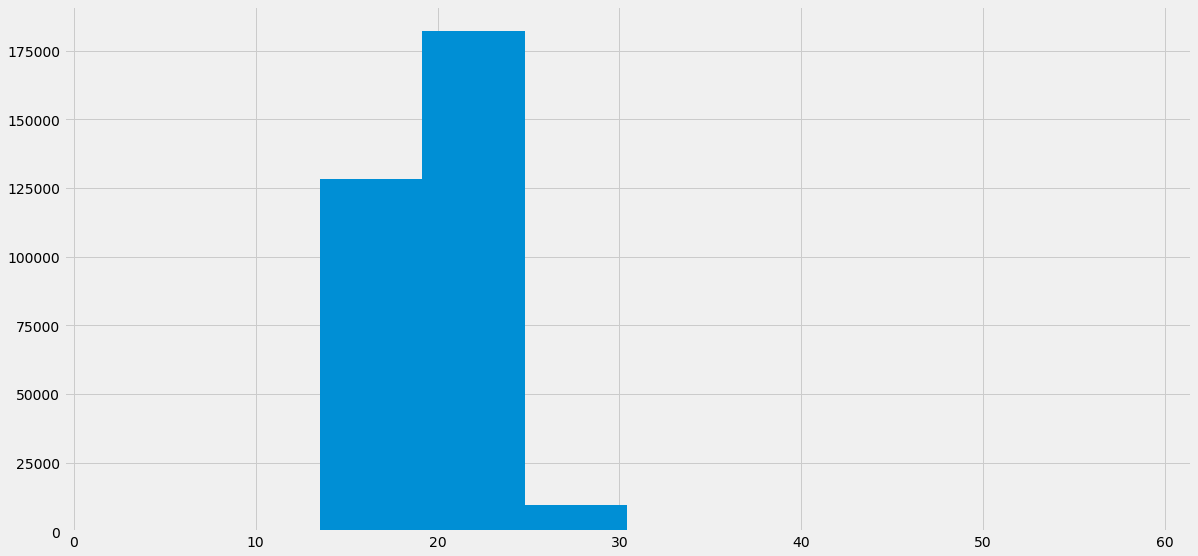

g


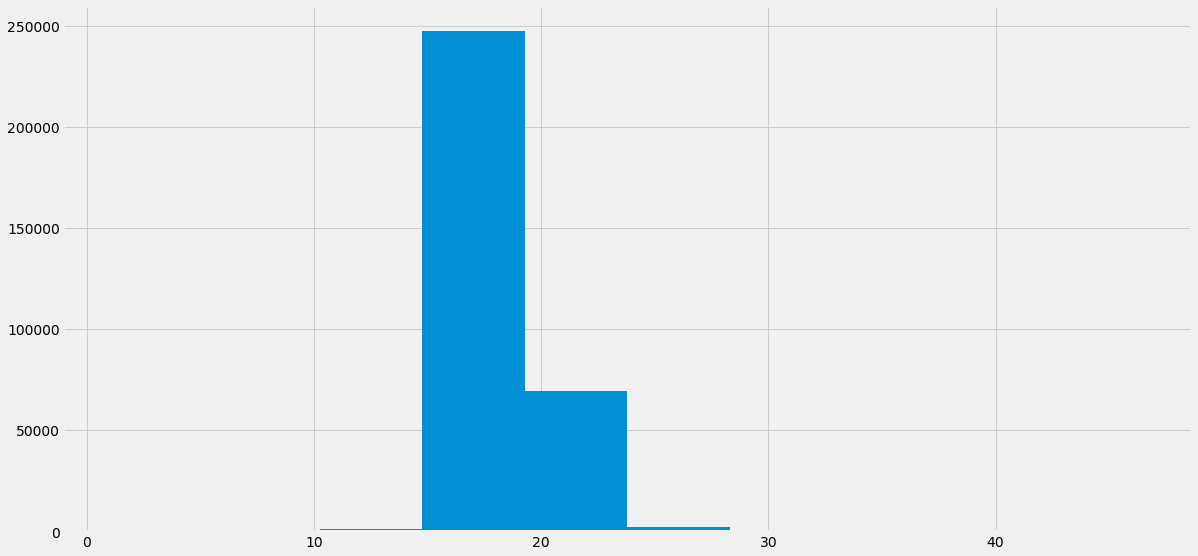

r


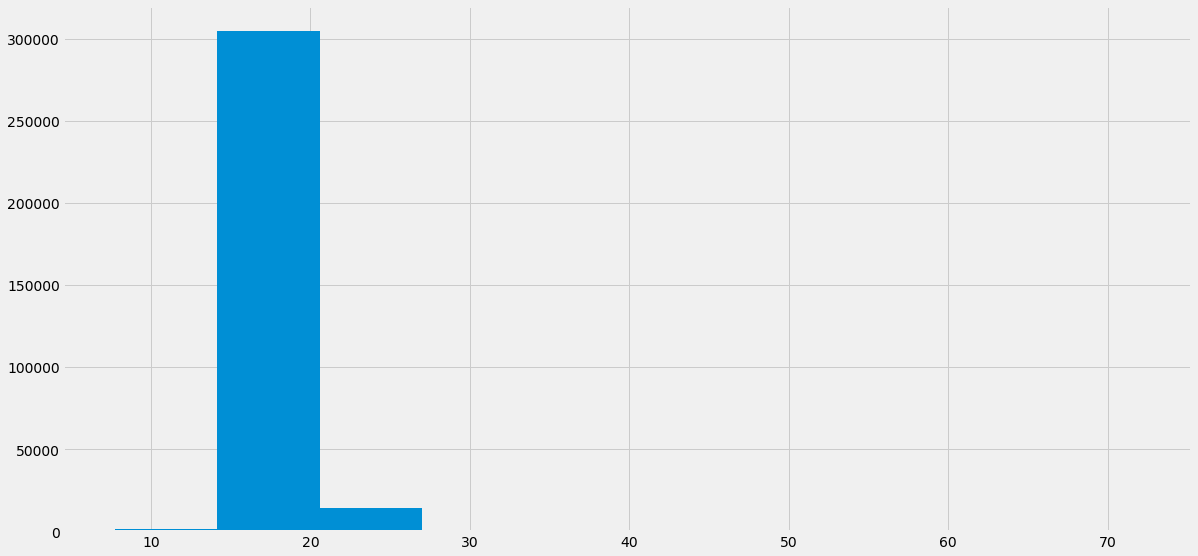

i


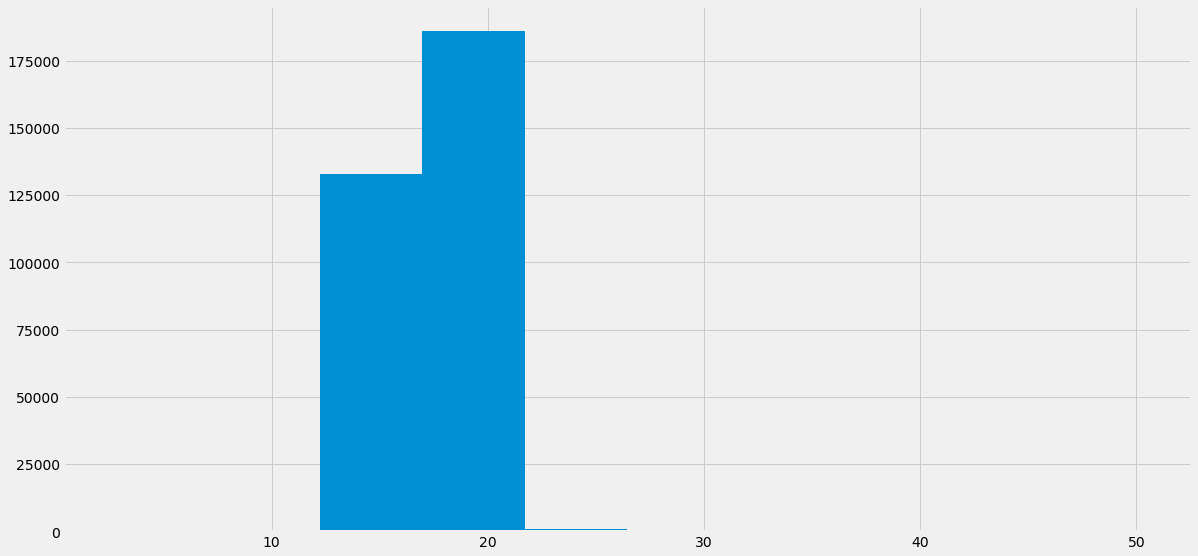

z


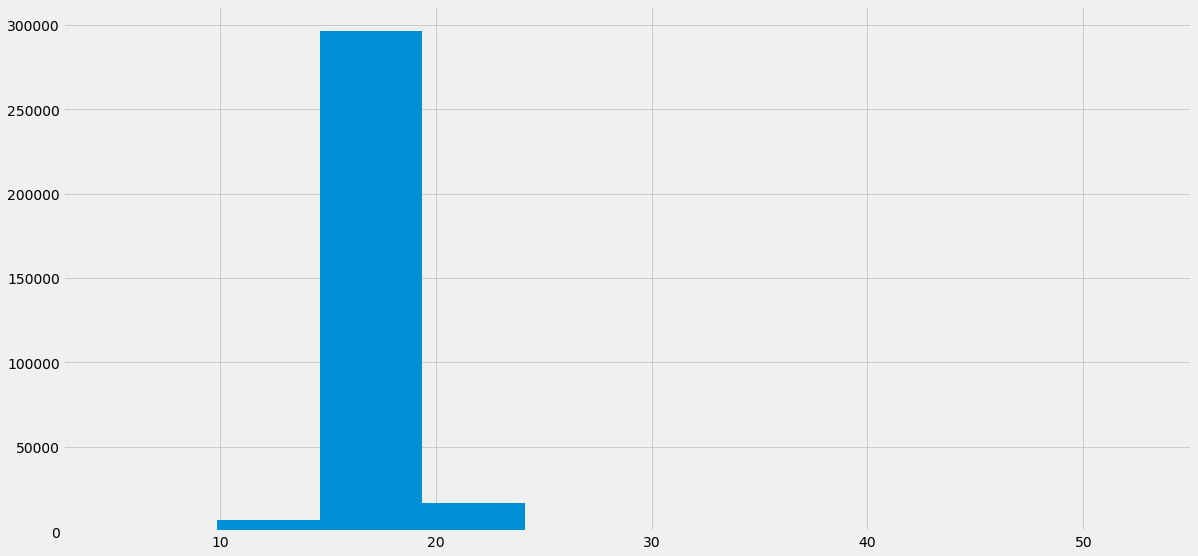

redshift


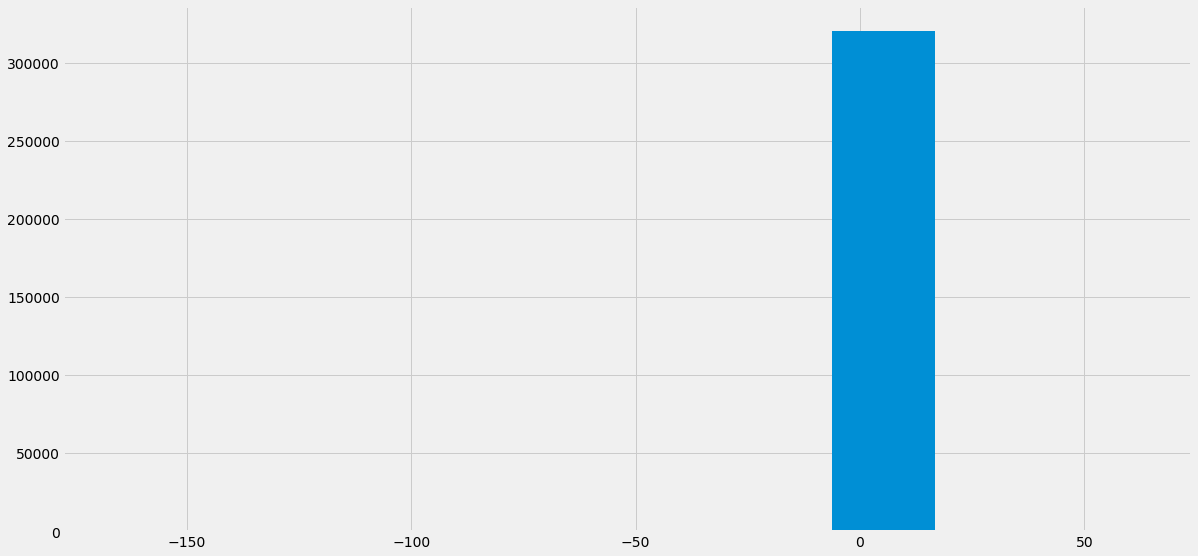

dered_u


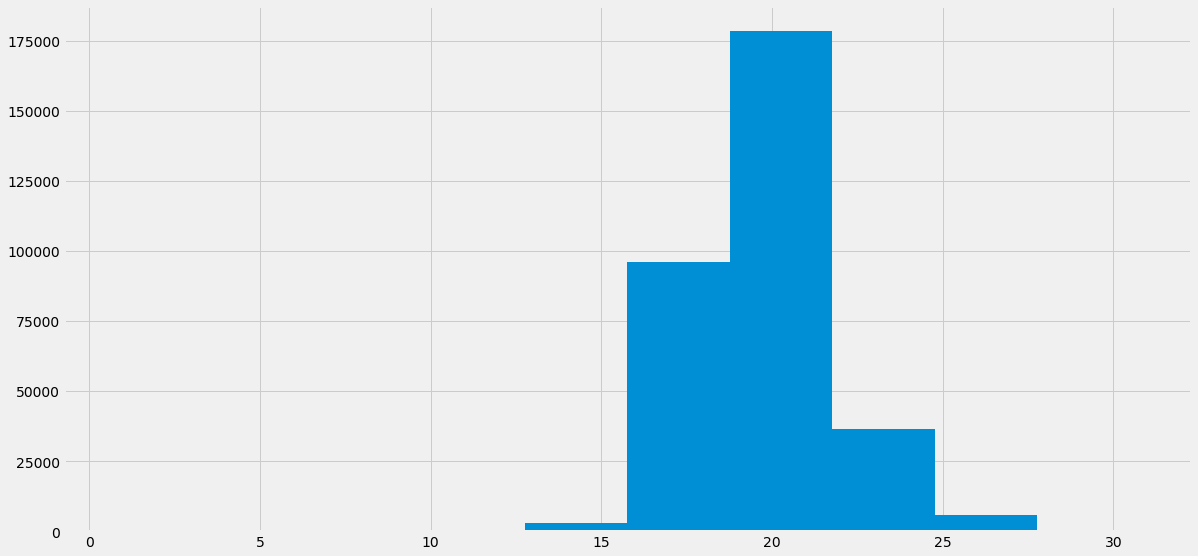

dered_g


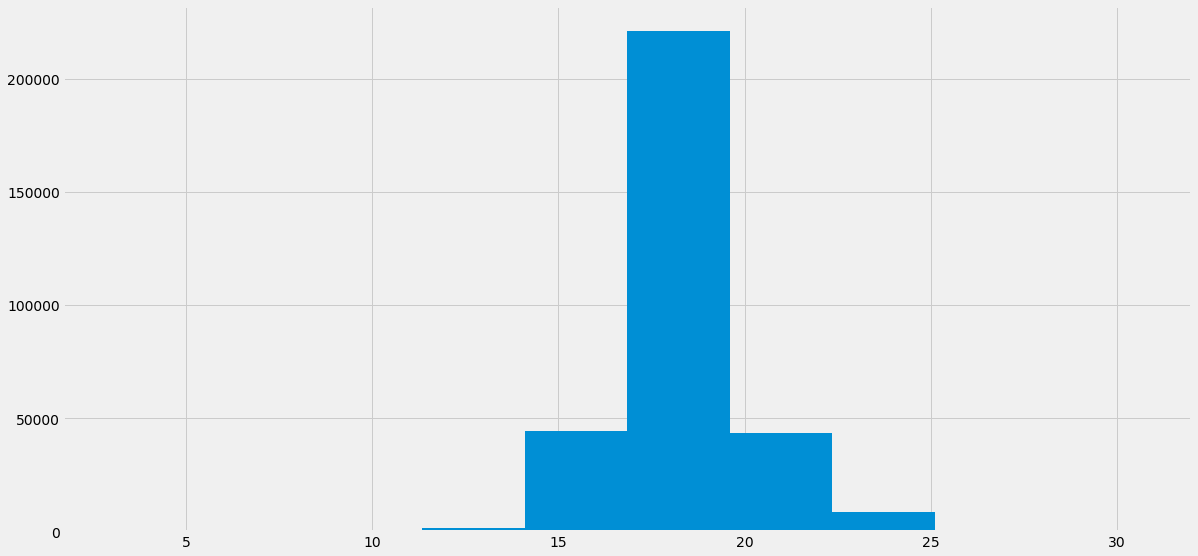

dered_r


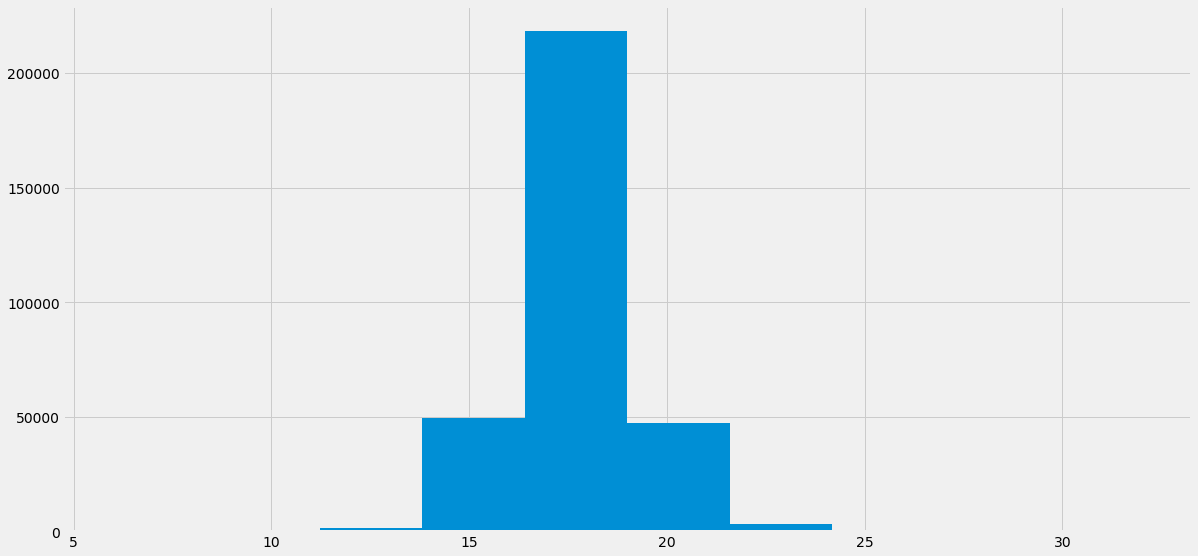

dered_i


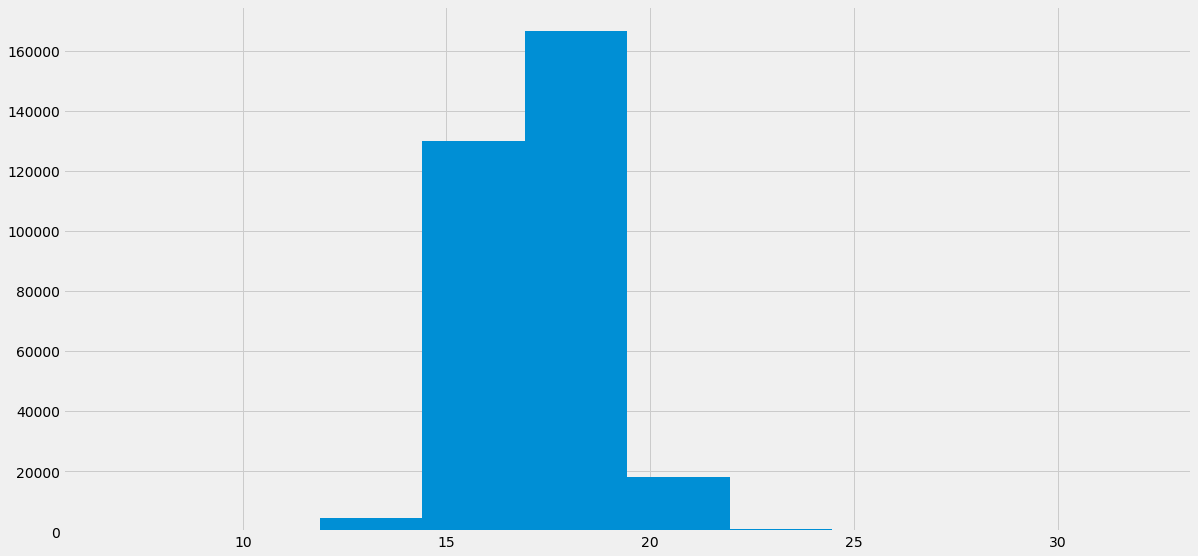

dered_z


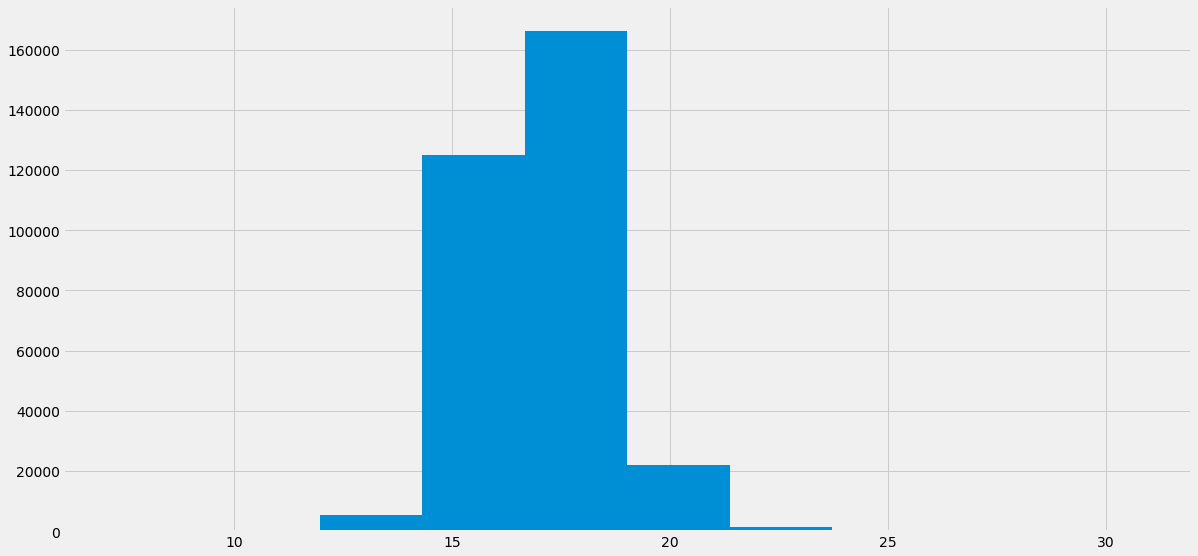

nObserve


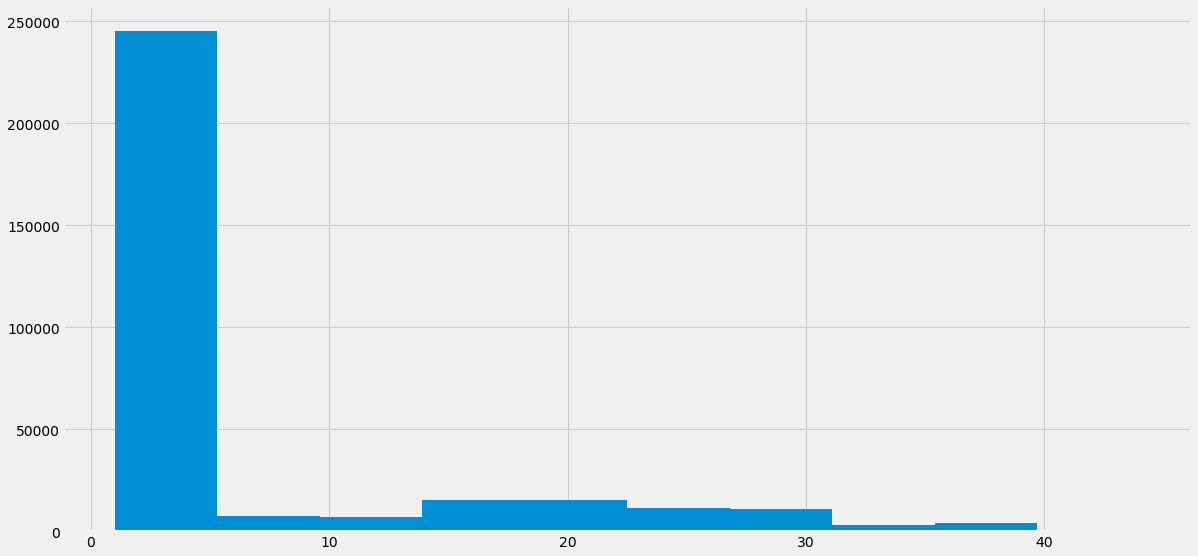

nDetect


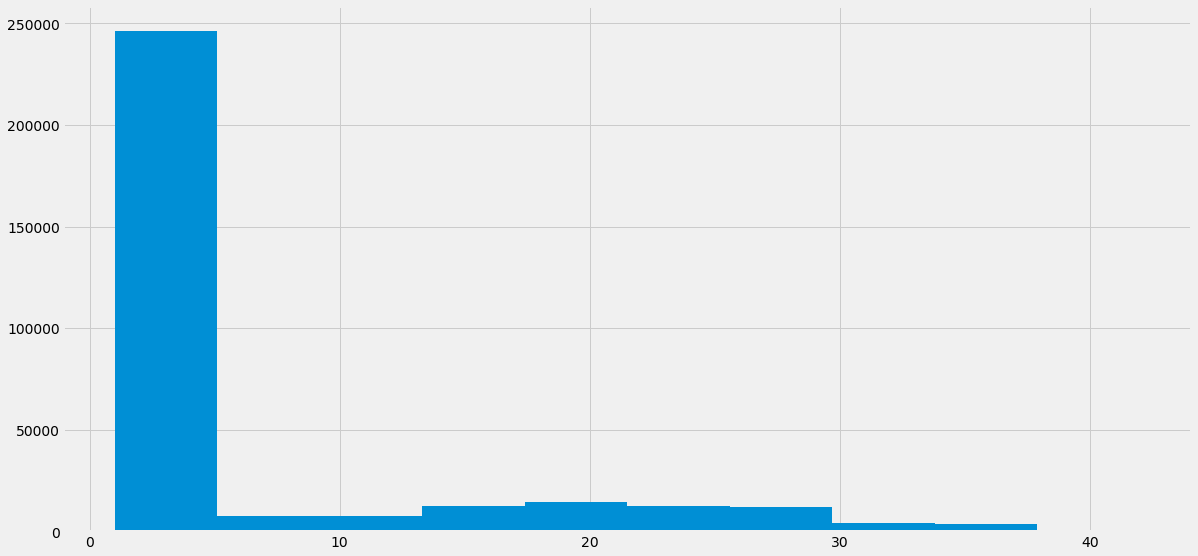

airmass_u


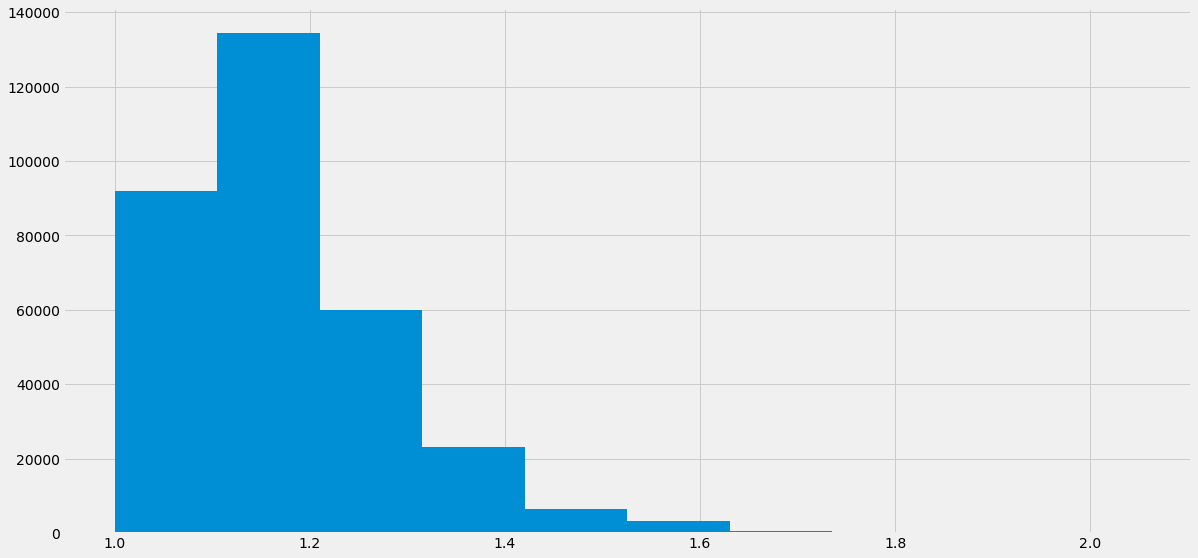

airmass_g


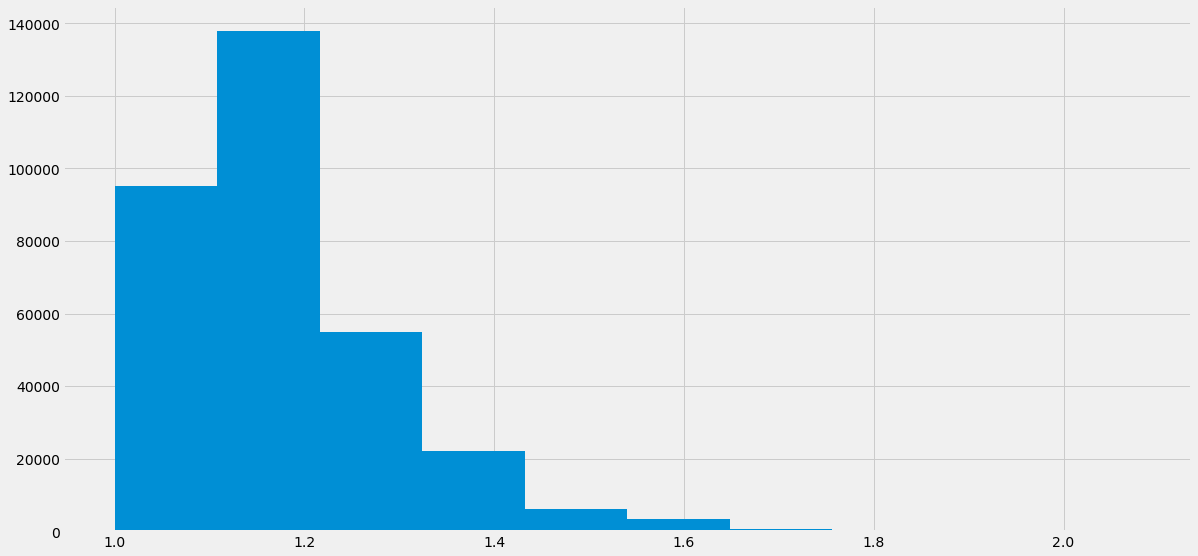

airmass_r


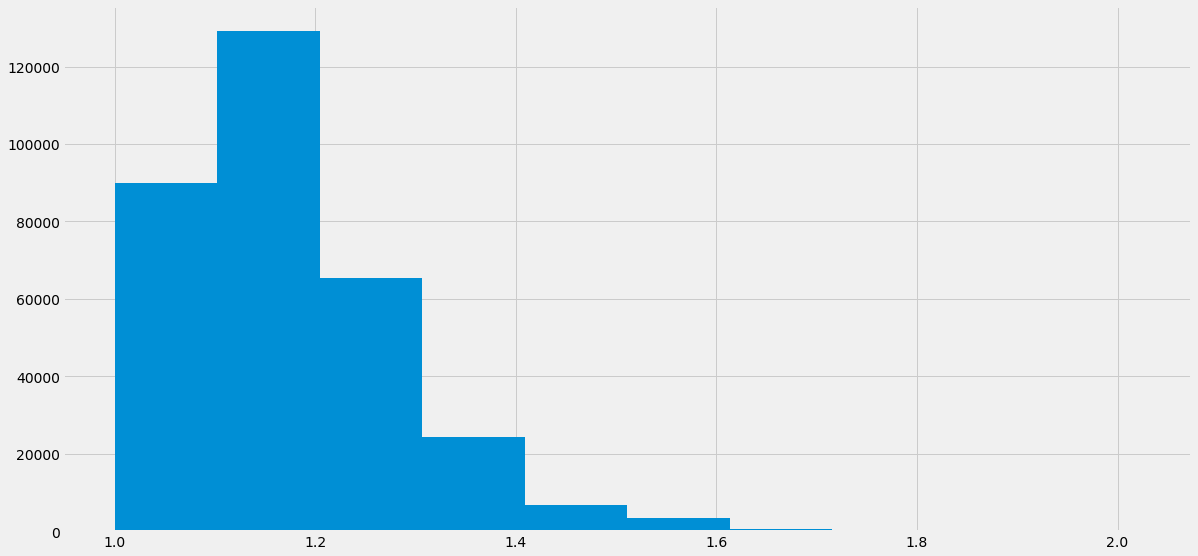

airmass_i


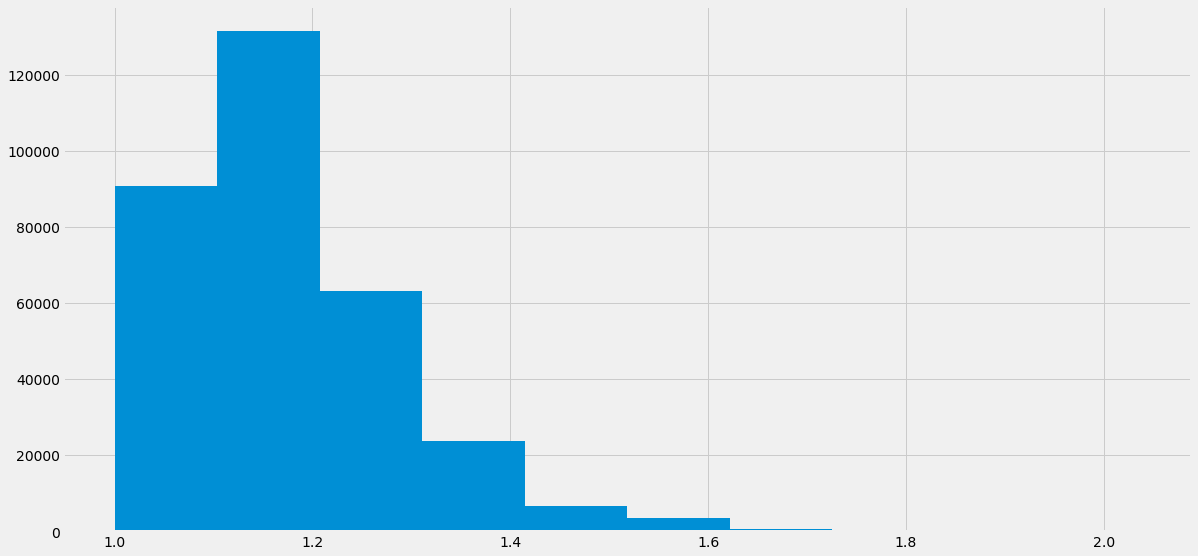

airmass_z


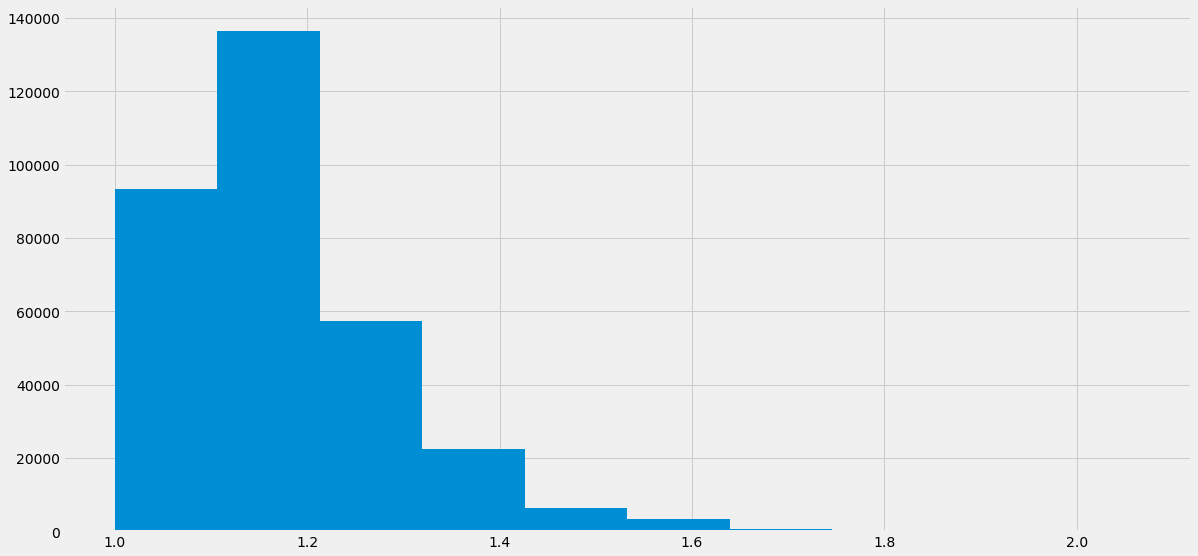

class


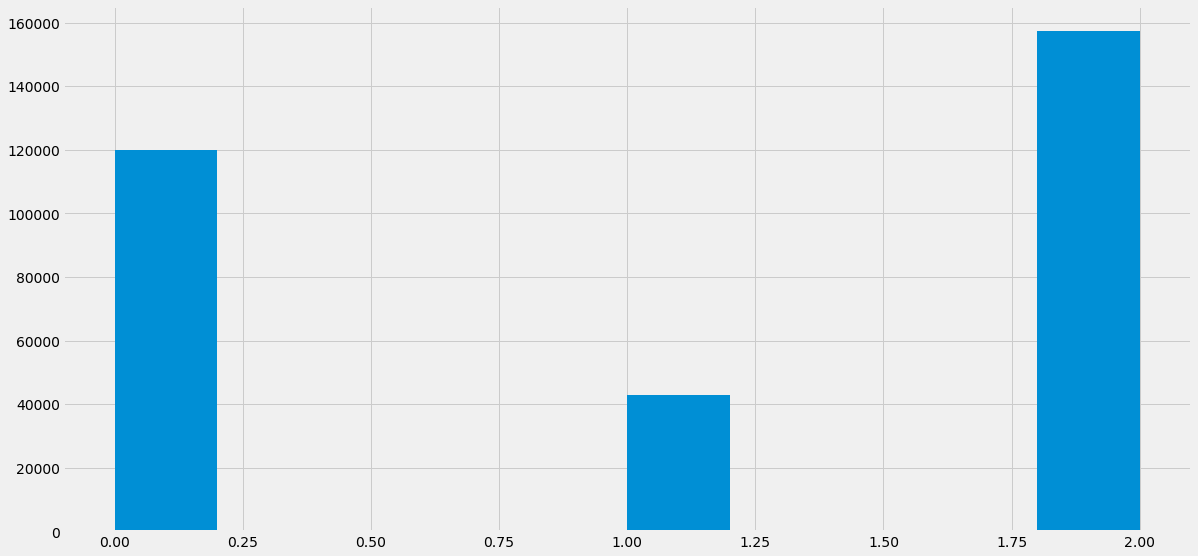

In [149]:
for i in trn1.columns:
    print(i)
    trn1[i].hist()
    plt.show()


In [150]:
tst = pd.read_csv(tst_file, index_col = 0)
tst

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z
id,,,,,,,,,,,,,,,,,,
320000,19.1431,18.0172,17.4733,17.1144,16.9263,1.2130e-01,19.0750,17.9550,17.4308,17.0838,16.9087,1,1,1.1563,1.1515,1.1613,1.1588,1.1539
320001,18.7409,17.1705,16.3691,15.9865,15.7307,-6.6907e-05,15.0703,14.3098,14.3901,14.5160,14.6372,2,2,1.0076,1.0074,1.0080,1.0078,1.0075
320002,19.2980,17.8803,17.2221,16.8096,16.6352,1.1001e-01,19.1004,17.7726,17.1460,16.7497,16.5689,1,1,1.3809,1.3905,1.3715,1.3761,1.3856
320003,18.0775,17.1569,16.9041,16.8118,16.7955,2.9697e-05,17.9729,17.0735,16.8470,16.7700,16.7668,1,1,1.1408,1.1408,1.1409,1.1408,1.1408
320004,17.8325,16.7646,16.2135,15.8722,15.6621,6.8471e-02,17.7545,16.6794,16.1563,15.8315,15.6433,2,2,1.1110,1.1077,1.1145,1.1127,1.1093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,19.6734,18.6617,18.2708,18.1225,18.0627,-3.1726e-04,19.3361,18.3933,18.0860,17.9861,17.9670,17,17,1.1858,1.1863,1.1855,1.1857,1.1861
399996,21.5229,20.7283,20.6087,21.0049,20.8458,6.5455e-02,21.3993,20.6399,20.5451,20.9507,20.7827,8,4,1.2850,1.2908,1.2793,1.2821,1.2878
399997,19.3991,18.2411,18.1605,18.1978,18.2018,-8.4180e-04,18.9136,17.8753,17.9047,18.0043,18.0400,1,1,1.1885,1.1886,1.1885,1.1885,1.1885


In [151]:
df = pd.concat([trn1, tst])
df

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
id,,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0.0
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1.0
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0.0
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057,0.0
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,19.6734,18.6617,18.2708,18.1225,18.0627,-3.1726e-04,19.3361,18.3933,18.0860,17.9861,17.9670,17,17,1.1858,1.1863,1.1855,1.1857,1.1861,NaN
399996,21.5229,20.7283,20.6087,21.0049,20.8458,6.5455e-02,21.3993,20.6399,20.5451,20.9507,20.7827,8,4,1.2850,1.2908,1.2793,1.2821,1.2878,NaN
399997,19.3991,18.2411,18.1605,18.1978,18.2018,-8.4180e-04,18.9136,17.8753,17.9047,18.0043,18.0400,1,1,1.1885,1.1886,1.1885,1.1885,1.1885,NaN


In [152]:
#dered - 한자리
df['d_dered_u'] = df['dered_u'] - df['u']
df['d_dered_g'] = df['dered_g'] - df['g']
df['d_dered_r'] = df['dered_r'] - df['r']
df['d_dered_i'] = df['dered_i'] - df['i']
df['d_dered_z'] = df['dered_z'] - df['z']
df['dered_ur'] = df['dered_u'] - df['r']
df['dered_gi'] = df['dered_g'] - df['i']
df['dered_gz'] = df['dered_g'] - df['z']
df['dered_ru'] = df['dered_r'] - df['u']
df['dered_ig'] = df['dered_i'] - df['g']
df['dered_iz'] = df['dered_i'] - df['z']
df['dered_zi'] = df['dered_z'] - df['i']

#dered - dered
df['d_dered_ur'] = df['dered_u'] - df['dered_r']
df['d_dered_rg'] = df['dered_r'] - df['dered_g']
df['d_dered_ig'] = df['dered_i'] - df['dered_g']
df['d_dered_zg'] = df['dered_z'] - df['dered_g']
df['d_dered_ri'] = df['dered_r'] - df['dered_i']
df['d_dered_rz'] = df['dered_r'] - df['dered_z']
df['d_dered_iz'] = df['dered_i'] - df['dered_z']
df['d_obs_det'] = df['nObserve'] - df['nDetect']

#airmass 끼리
df['air_ug'] = df['airmass_u'] - df['airmass_g']
df['air_ur'] = df['airmass_u'] - df['airmass_r']
df['air_ui'] = df['airmass_u'] - df['airmass_i']
df['air_uz'] = df['airmass_u'] - df['airmass_z']
df['air_gr'] = df['airmass_g'] - df['airmass_r']
df['air_gi'] = df['airmass_g'] - df['airmass_i']
df['air_gz'] = df['airmass_g'] - df['airmass_z']
df['air_ri'] = df['airmass_r'] - df['airmass_i']
df['air_rz'] = df['airmass_r'] - df['airmass_z']
df['air_iz'] = df['airmass_i'] - df['airmass_z']

#한자리 끼리
df['ur'] = df['u'] - df['r']
df['ug'] = df['u'] - df['g']
df['gi'] = df['g'] - df['i']
df['gz'] = df['g'] - df['z']
df['iz'] = df['i'] - df['z']

# 
df

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,dered_ur,dered_gi,dered_gz,dered_ru,dered_ig,dered_iz,dered_zi,d_dered_ur,d_dered_rg,d_dered_ig,d_dered_zg,d_dered_ri,d_dered_rz,d_dered_iz,d_obs_det,air_ug,air_ur,air_ui,air_uz,air_gr,air_gi,air_gz,air_ri,air_rz,air_iz,ur,ug,gi,gz,iz
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,4.1148,2.5854,3.3182,-4.3088,-2.7047,0.6925,-0.7635,4.1691,-1.3027,-2.6257,-3.3488,1.3230,2.0462,0.7232,0,-9.1700e-04,7.8500e-04,4.0900e-04,-4.4200e-04,1.7020e-03,1.3260e-03,4.7500e-04,-3.7600e-04,-1.2270e-03,-8.5100e-04,4.2545,2.9272,2.6643,3.3972,0.7328
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,1.5140,0.7361,0.8356,-1.6408,-0.8257,0.0673,-0.1338,1.5550,-0.5931,-0.7683,-0.8698,0.1751,0.2767,0.1016,0,-4.5820e-03,4.4920e-03,2.2570e-03,-2.2790e-03,9.0740e-03,6.8390e-03,2.3030e-03,-2.2350e-03,-6.7710e-03,-4.5360e-03,1.5997,0.9902,0.7935,0.8930,0.0995
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,1.0713,0.2931,0.3366,-1.3463,-0.5037,-0.0283,-0.0975,1.1676,-0.2466,-0.3649,-0.3905,0.1183,0.1440,0.0257,0,-1.6060e-03,1.5160e-03,7.6900e-04,-7.9200e-04,3.1220e-03,2.3750e-03,8.1400e-04,-7.4700e-04,-2.3080e-03,-1.5610e-03,1.2501,0.9610,0.4319,0.4754,0.0435
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,5.1325,1.0997,1.3600,-5.5734,-1.3941,0.1600,-0.3398,5.2664,-0.9074,-1.2000,-1.4395,0.2926,0.5321,0.2395,1,-6.5900e-04,5.2500e-04,2.7900e-04,-3.1300e-04,1.1840e-03,9.3800e-04,3.4600e-04,-2.4600e-04,-8.3800e-04,-5.9200e-04,5.4395,4.4719,1.2938,1.5541,0.2603
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,4.7290,2.1097,2.4512,-5.5904,-2.5089,0.2076,-0.4482,4.9084,-1.5709,-2.2436,-2.5579,0.6727,0.9871,0.3144,1,-3.3900e-04,2.0800e-04,1.2000e-04,-1.5300e-04,5.4700e-04,4.5900e-04,1.8600e-04,-8.8000e-05,-3.6100e-04,-2.7300e-04,5.4111,3.7543,2.3750,2.7165,0.3415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,19.6734,18.6617,18.2708,18.1225,18.0627,-3.1726e-04,19.3361,18.3933,18.0860,17.9861,17.9670,17,17,1.1858,1.1863,1.1855,1.1857,1.1861,NaN,-0.3372,-0.2684,-0.1848,-0.1364,-0.0957,1.0654,0.2708,0.3306,-1.5874,-0.6756,-0.0766,-0.1555,1.2501,-0.3073,-0.4072,-0.4263,0.0999,0.1190,0.0191,0,-4.7900e-04,3.5000e-04,1.9100e-04,-2.2400e-04,8.2900e-04,6.7000e-04,2.5500e-04,-1.5900e-04,-5.7400e-04,-4.1500e-04,1.4026,1.0117,0.5392,0.5990,0.0598
399996,21.5229,20.7283,20.6087,21.0049,20.8458,6.5455e-02,21.3993,20.6399,20.5451,20.9507,20.7827,8,4,1.2850,1.2908,1.2793,1.2821,1.2878,NaN,-0.1235,-0.0884,-0.0636,-0.0542,-0.0631,0.7907,-0.3650,-0.2059,-0.9778,0.2224,0.1049,-0.2222,0.8543,-0.0949,0.3108,0.1428,-0.4056,-0.2376,0.1680,4,-5.8160e-03,5.6270e-03,2.8360e-03,-2.8820e-03,1.1443e-02,8.6520e-03,2.9340e-03,-2.7910e-03,-8.5090e-03,-5.7180e-03,0.9142,0.7946,-0.2766,-0.1175,0.1591
399997,19.3991,18.2411,18.1605,18.1978,18.2018,-8.4180e-04,18.9136,17.8753,17.9047,18.0043,18.0400,1,1,1.1885,1.1886,1.1885,1.1885,1.1885,NaN,-0.4855,-0.3657,-0.2558,-0.1935,-0.1618,0.7531,-0.3224,-0.3265,-1.4944,-0.2368,-0.1976,-0.1578,1.0089,0.0294,0.1289

In [153]:
# 첨도부분 처리
df['airmass_g'] = np.sqrt(np.log(df['airmass_g']))
df['airmass_i'] = np.sqrt(np.log(df['airmass_i']))
df['airmass_r'] = np.sqrt(np.log(df['airmass_r']))
#Train_copy1['airmass_r'] = np.log(Train_copy1['airmass_r'])
#Train_copy1['airmass_u'] = np.log1p(np.log1p(Train_copy1['airmass_u']))
#Train_copy1['airmass_z'] = np.log1p(np.log1p(Train_copy1['airmass_z']))
df['airmass_u'] = np.sqrt(np.log(df['airmass_u']))
df['airmass_z'] = np.sqrt(np.log(df['airmass_z']))

#Train_copy1['nDetect'] = np.log(Train_copy1['nDetect'])
df['nDetect'] = np.log(df['nDetect'])
#Train_copy1['nObserve'] = np.log1p(Train_copy1['nObserve']) #sqrt ,cbrt
df['nObserve'] = np.log(df['nObserve'])

df['r'] = np.log(df['r'])
df['u'] = np.log(df['u'])
df['g'] = np.log(df['g'])
df['i'] = np.log(df['i'])
df['z'] = np.log(df['z'])

df['dered_r'] = np.sqrt(np.log(df['dered_r']))
df['dered_i'] = np.sqrt(np.log(df['dered_i']))
df['dered_u'] = np.sqrt(np.log(df['dered_u']))
df['dered_g'] = np.sqrt(np.log(df['dered_g']))
df['dered_z'] = np.sqrt(np.log(df['dered_z']))


In [154]:
y = df[target_col].values[:319978]
df.drop(target_col, axis=1, inplace=True)
trn2 = df.iloc[:319978]
tst2 = df.iloc[319978:]
feature_name = df.columns.tolist()
print(y.shape, trn2.shape, tst2.shape)

(319978,) (319978, 53) (80000, 53)


In [155]:
X_trn, X_val, y_trn, y_val = train_test_split(trn2, y, test_size=.2, random_state=seed)
print(X_trn.shape, X_val.shape, y_trn.shape, y_val.shape)

clf = lgb.LGBMClassifier(objective='multiclass',
                         n_estimators=10000,
                         num_leaves=256,
                         learning_rate=0.005,
                         min_child_samples=10,
                         subsample=.5,
                         subsample_freq=1,
                         colsample_bytree=.8,
                         random_state=seed,
                         max_depth = 27,
                         n_jobs=-1)
clf.fit(X_trn, y_trn,
        eval_set=[(X_val, y_val)],
        eval_metric='multiclass',
        early_stopping_rounds=100)
p_val = clf.predict(X_val)
p_tst = clf.predict(tst2)

print(f'{accuracy_score(y_val, p_val) * 100:.4f}%')

(255982, 53) (63996, 53) (255982,) (63996,)
[1]	valid_0's multi_logloss: 0.976477
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.968832
[3]	valid_0's multi_logloss: 0.961357
[4]	valid_0's multi_logloss: 0.95397
[5]	valid_0's multi_logloss: 0.946825
[6]	valid_0's multi_logloss: 0.939639
[7]	valid_0's multi_logloss: 0.932523
[8]	valid_0's multi_logloss: 0.925546
[9]	valid_0's multi_logloss: 0.918907
[10]	valid_0's multi_logloss: 0.912038
[11]	valid_0's multi_logloss: 0.905761
[12]	valid_0's multi_logloss: 0.899104
[13]	valid_0's multi_logloss: 0.892472
[14]	valid_0's multi_logloss: 0.886129
[15]	valid_0's multi_logloss: 0.879652
[16]	valid_0's multi_logloss: 0.873529
[17]	valid_0's multi_logloss: 0.867237
[18]	valid_0's multi_logloss: 0.861166
[19]	valid_0's multi_logloss: 0.855326
[20]	valid_0's multi_logloss: 0.849259
[21]	valid_0's multi_logloss: 0.843757
[22]	valid_0's multi_logloss: 0.837836
[23]	valid_0's multi_logloss: 0.832374
[24]	va

[207]	valid_0's multi_logloss: 0.336652
[208]	valid_0's multi_logloss: 0.335485
[209]	valid_0's multi_logloss: 0.334297
[210]	valid_0's multi_logloss: 0.33326
[211]	valid_0's multi_logloss: 0.332222
[212]	valid_0's multi_logloss: 0.331095
[213]	valid_0's multi_logloss: 0.329935
[214]	valid_0's multi_logloss: 0.328778
[215]	valid_0's multi_logloss: 0.327628
[216]	valid_0's multi_logloss: 0.326569
[217]	valid_0's multi_logloss: 0.325442
[218]	valid_0's multi_logloss: 0.324325
[219]	valid_0's multi_logloss: 0.323202
[220]	valid_0's multi_logloss: 0.322179
[221]	valid_0's multi_logloss: 0.321083
[222]	valid_0's multi_logloss: 0.320048
[223]	valid_0's multi_logloss: 0.31905
[224]	valid_0's multi_logloss: 0.317982
[225]	valid_0's multi_logloss: 0.316991
[226]	valid_0's multi_logloss: 0.315962
[227]	valid_0's multi_logloss: 0.314906
[228]	valid_0's multi_logloss: 0.313862
[229]	valid_0's multi_logloss: 0.312911
[230]	valid_0's multi_logloss: 0.311877
[231]	valid_0's multi_logloss: 0.310904
[2

[415]	valid_0's multi_logloss: 0.207122
[416]	valid_0's multi_logloss: 0.20684
[417]	valid_0's multi_logloss: 0.206563
[418]	valid_0's multi_logloss: 0.20629
[419]	valid_0's multi_logloss: 0.205989
[420]	valid_0's multi_logloss: 0.205709
[421]	valid_0's multi_logloss: 0.20542
[422]	valid_0's multi_logloss: 0.205123
[423]	valid_0's multi_logloss: 0.204885
[424]	valid_0's multi_logloss: 0.204627
[425]	valid_0's multi_logloss: 0.204359
[426]	valid_0's multi_logloss: 0.204067
[427]	valid_0's multi_logloss: 0.203811
[428]	valid_0's multi_logloss: 0.203524
[429]	valid_0's multi_logloss: 0.20327
[430]	valid_0's multi_logloss: 0.203021
[431]	valid_0's multi_logloss: 0.202797
[432]	valid_0's multi_logloss: 0.202543
[433]	valid_0's multi_logloss: 0.202308
[434]	valid_0's multi_logloss: 0.202065
[435]	valid_0's multi_logloss: 0.201819
[436]	valid_0's multi_logloss: 0.201586
[437]	valid_0's multi_logloss: 0.201312
[438]	valid_0's multi_logloss: 0.201046
[439]	valid_0's multi_logloss: 0.200804
[440

[622]	valid_0's multi_logloss: 0.172212
[623]	valid_0's multi_logloss: 0.172114
[624]	valid_0's multi_logloss: 0.172028
[625]	valid_0's multi_logloss: 0.171941
[626]	valid_0's multi_logloss: 0.17185
[627]	valid_0's multi_logloss: 0.171769
[628]	valid_0's multi_logloss: 0.171683
[629]	valid_0's multi_logloss: 0.171586
[630]	valid_0's multi_logloss: 0.171504
[631]	valid_0's multi_logloss: 0.171413
[632]	valid_0's multi_logloss: 0.171334
[633]	valid_0's multi_logloss: 0.171241
[634]	valid_0's multi_logloss: 0.17116
[635]	valid_0's multi_logloss: 0.171082
[636]	valid_0's multi_logloss: 0.171007
[637]	valid_0's multi_logloss: 0.170919
[638]	valid_0's multi_logloss: 0.170841
[639]	valid_0's multi_logloss: 0.170771
[640]	valid_0's multi_logloss: 0.17069
[641]	valid_0's multi_logloss: 0.170608
[642]	valid_0's multi_logloss: 0.170528
[643]	valid_0's multi_logloss: 0.17045
[644]	valid_0's multi_logloss: 0.170365
[645]	valid_0's multi_logloss: 0.170283
[646]	valid_0's multi_logloss: 0.1702
[647]	

[829]	valid_0's multi_logloss: 0.160521
[830]	valid_0's multi_logloss: 0.160492
[831]	valid_0's multi_logloss: 0.160457
[832]	valid_0's multi_logloss: 0.160429
[833]	valid_0's multi_logloss: 0.1604
[834]	valid_0's multi_logloss: 0.16037
[835]	valid_0's multi_logloss: 0.160337
[836]	valid_0's multi_logloss: 0.160309
[837]	valid_0's multi_logloss: 0.160278
[838]	valid_0's multi_logloss: 0.160242
[839]	valid_0's multi_logloss: 0.160213
[840]	valid_0's multi_logloss: 0.160183
[841]	valid_0's multi_logloss: 0.160153
[842]	valid_0's multi_logloss: 0.160127
[843]	valid_0's multi_logloss: 0.160095
[844]	valid_0's multi_logloss: 0.160068
[845]	valid_0's multi_logloss: 0.160045
[846]	valid_0's multi_logloss: 0.160014
[847]	valid_0's multi_logloss: 0.159976
[848]	valid_0's multi_logloss: 0.159947
[849]	valid_0's multi_logloss: 0.159923
[850]	valid_0's multi_logloss: 0.159889
[851]	valid_0's multi_logloss: 0.159853
[852]	valid_0's multi_logloss: 0.159827
[853]	valid_0's multi_logloss: 0.159795
[85

[1036]	valid_0's multi_logloss: 0.156116
[1037]	valid_0's multi_logloss: 0.156099
[1038]	valid_0's multi_logloss: 0.156089
[1039]	valid_0's multi_logloss: 0.156076
[1040]	valid_0's multi_logloss: 0.156062
[1041]	valid_0's multi_logloss: 0.156043
[1042]	valid_0's multi_logloss: 0.156027
[1043]	valid_0's multi_logloss: 0.156016
[1044]	valid_0's multi_logloss: 0.156001
[1045]	valid_0's multi_logloss: 0.155988
[1046]	valid_0's multi_logloss: 0.155974
[1047]	valid_0's multi_logloss: 0.155961
[1048]	valid_0's multi_logloss: 0.155951
[1049]	valid_0's multi_logloss: 0.155937
[1050]	valid_0's multi_logloss: 0.155923
[1051]	valid_0's multi_logloss: 0.155912
[1052]	valid_0's multi_logloss: 0.155893
[1053]	valid_0's multi_logloss: 0.155881
[1054]	valid_0's multi_logloss: 0.155867
[1055]	valid_0's multi_logloss: 0.155859
[1056]	valid_0's multi_logloss: 0.155853
[1057]	valid_0's multi_logloss: 0.15584
[1058]	valid_0's multi_logloss: 0.15583
[1059]	valid_0's multi_logloss: 0.155815
[1060]	valid_0's m

[1237]	valid_0's multi_logloss: 0.15425
[1238]	valid_0's multi_logloss: 0.154245
[1239]	valid_0's multi_logloss: 0.154237
[1240]	valid_0's multi_logloss: 0.154234
[1241]	valid_0's multi_logloss: 0.154229
[1242]	valid_0's multi_logloss: 0.154224
[1243]	valid_0's multi_logloss: 0.154219
[1244]	valid_0's multi_logloss: 0.154212
[1245]	valid_0's multi_logloss: 0.154209
[1246]	valid_0's multi_logloss: 0.154199
[1247]	valid_0's multi_logloss: 0.154194
[1248]	valid_0's multi_logloss: 0.154188
[1249]	valid_0's multi_logloss: 0.154184
[1250]	valid_0's multi_logloss: 0.154181
[1251]	valid_0's multi_logloss: 0.154177
[1252]	valid_0's multi_logloss: 0.154169
[1253]	valid_0's multi_logloss: 0.154162
[1254]	valid_0's multi_logloss: 0.154156
[1255]	valid_0's multi_logloss: 0.154155
[1256]	valid_0's multi_logloss: 0.154148
[1257]	valid_0's multi_logloss: 0.154146
[1258]	valid_0's multi_logloss: 0.15414
[1259]	valid_0's multi_logloss: 0.154136
[1260]	valid_0's multi_logloss: 0.154133
[1261]	valid_0's m

[1439]	valid_0's multi_logloss: 0.153438
[1440]	valid_0's multi_logloss: 0.153437
[1441]	valid_0's multi_logloss: 0.153433
[1442]	valid_0's multi_logloss: 0.153429
[1443]	valid_0's multi_logloss: 0.153427
[1444]	valid_0's multi_logloss: 0.153424
[1445]	valid_0's multi_logloss: 0.153422
[1446]	valid_0's multi_logloss: 0.153421
[1447]	valid_0's multi_logloss: 0.153419
[1448]	valid_0's multi_logloss: 0.153417
[1449]	valid_0's multi_logloss: 0.153417
[1450]	valid_0's multi_logloss: 0.153412
[1451]	valid_0's multi_logloss: 0.153409
[1452]	valid_0's multi_logloss: 0.153406
[1453]	valid_0's multi_logloss: 0.153405
[1454]	valid_0's multi_logloss: 0.153405
[1455]	valid_0's multi_logloss: 0.153406
[1456]	valid_0's multi_logloss: 0.153403
[1457]	valid_0's multi_logloss: 0.153402
[1458]	valid_0's multi_logloss: 0.153401
[1459]	valid_0's multi_logloss: 0.153399
[1460]	valid_0's multi_logloss: 0.153397
[1461]	valid_0's multi_logloss: 0.153397
[1462]	valid_0's multi_logloss: 0.153398
[1463]	valid_0's

[1641]	valid_0's multi_logloss: 0.153116
[1642]	valid_0's multi_logloss: 0.153117
[1643]	valid_0's multi_logloss: 0.15312
[1644]	valid_0's multi_logloss: 0.153118
[1645]	valid_0's multi_logloss: 0.153118
[1646]	valid_0's multi_logloss: 0.153115
[1647]	valid_0's multi_logloss: 0.153115
[1648]	valid_0's multi_logloss: 0.153117
[1649]	valid_0's multi_logloss: 0.153115
[1650]	valid_0's multi_logloss: 0.153116
[1651]	valid_0's multi_logloss: 0.153117
[1652]	valid_0's multi_logloss: 0.153118
[1653]	valid_0's multi_logloss: 0.153115
[1654]	valid_0's multi_logloss: 0.153114
[1655]	valid_0's multi_logloss: 0.153113
[1656]	valid_0's multi_logloss: 0.153113
[1657]	valid_0's multi_logloss: 0.153111
[1658]	valid_0's multi_logloss: 0.153109
[1659]	valid_0's multi_logloss: 0.153107
[1660]	valid_0's multi_logloss: 0.15311
[1661]	valid_0's multi_logloss: 0.153106
[1662]	valid_0's multi_logloss: 0.153108
[1663]	valid_0's multi_logloss: 0.153105
[1664]	valid_0's multi_logloss: 0.153108
[1665]	valid_0's m

[1842]	valid_0's multi_logloss: 0.153067
[1843]	valid_0's multi_logloss: 0.153066
[1844]	valid_0's multi_logloss: 0.153066
[1845]	valid_0's multi_logloss: 0.153069
[1846]	valid_0's multi_logloss: 0.15307
[1847]	valid_0's multi_logloss: 0.153072
[1848]	valid_0's multi_logloss: 0.153068
[1849]	valid_0's multi_logloss: 0.153067
[1850]	valid_0's multi_logloss: 0.153071
[1851]	valid_0's multi_logloss: 0.153072
[1852]	valid_0's multi_logloss: 0.153074
[1853]	valid_0's multi_logloss: 0.153075
[1854]	valid_0's multi_logloss: 0.153075
[1855]	valid_0's multi_logloss: 0.153075
[1856]	valid_0's multi_logloss: 0.153076
[1857]	valid_0's multi_logloss: 0.153076
[1858]	valid_0's multi_logloss: 0.153075
[1859]	valid_0's multi_logloss: 0.153075
[1860]	valid_0's multi_logloss: 0.15308
[1861]	valid_0's multi_logloss: 0.153081
[1862]	valid_0's multi_logloss: 0.153082
[1863]	valid_0's multi_logloss: 0.153082
[1864]	valid_0's multi_logloss: 0.153081
[1865]	valid_0's multi_logloss: 0.15308
[1866]	valid_0's mu

<AxesSubplot:ylabel='feature'>

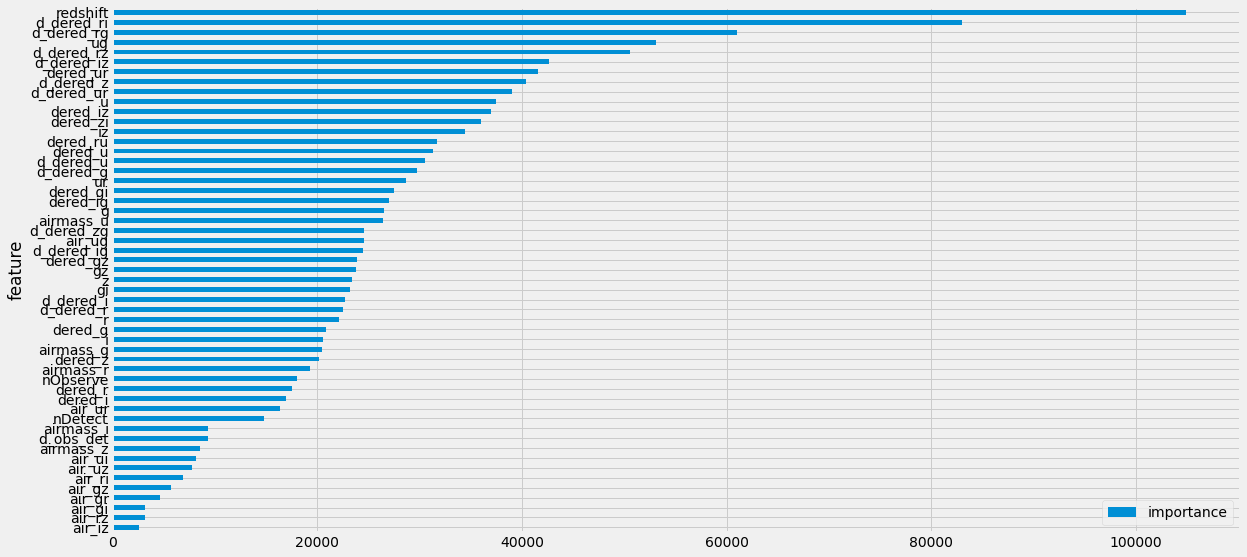

In [156]:
imp = pd.DataFrame({'feature': trn2.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [157]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [158]:
sub[target_col] = p_tst
sub.head()

,class
id,
320000,2.0
320001,0.0
320002,2.0
320003,0.0
320004,2.0


In [159]:
sub[target_col].value_counts()

2.0    40680
0.0    29964
1.0     9356
Name: class, dtype: int64

In [160]:
sub.to_csv(sub_file)